In [ ]:
import json
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.metrics.pairwise import cosine_similarity
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter, defaultdict
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

In [ ]:
class SemanticPatentClusterer:
    def __init__(self, jsonl_file_path, model_name='all-MiniLM-L6-v2'):
        """
        Initialize with patent data and SBERT model

        Popular model options:
        - 'all-MiniLM-L6-v2': Fast, good general performance (384 dim)
        - 'all-mpnet-base-v2': Better quality, slower (768 dim)
        - 'all-distilroberta-v1': Good balance (768 dim)
        """
        self.data = self.load_data(jsonl_file_path)
        self.model_name = model_name
        self.sbert_model = None
        self.embeddings = None
        self.cluster_labels = None
        self.processed_texts = None

        # Download required NLTK data
        try:
            nltk.data.find('tokenizers/punkt')
            nltk.data.find('corpora/stopwords')
            nltk.data.find('corpora/wordnet')
        except LookupError:
            nltk.download('punkt')
            nltk.download('stopwords')
            nltk.download('wordnet')

    def load_data(self, file_path):
        """Load and parse JSONL file"""
        data = []
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                data.append(json.loads(line.strip()))
        return pd.DataFrame(data)

    def preprocess_patent_text(self, text):
        """
        Lighter preprocessing for SBERT - preserve more semantic context
        SBERT handles context better, so we don't need aggressive preprocessing
        """
        if pd.isna(text) or text == '':
            return ''

        # Basic cleaning while preserving technical terms
        text = re.sub(r'\b(fig\.|figure)\s*\d+\b', 'figure', text, flags=re.IGNORECASE)
        text = re.sub(r'\bclaim\s*\d+\b', 'claim', text, flags=re.IGNORECASE)

        # Remove excessive whitespace and special chars but keep hyphens
        text = re.sub(r'[^\w\s\-\.]', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()

        # Truncate very long texts (SBERT has token limits)
        words = text.split()
        if len(words) > 500:  # Keep to ~500 words for better processing
            text = ' '.join(words[:500])

        return text

    def prepare_semantic_corpus(self):
        """Prepare text corpus for semantic embedding"""
        print("Preparing semantic corpus...")

        # Combine claims into single text
        self.data['claims_text'] = self.data['claims'].apply(
            lambda x: ' '.join(x) if isinstance(x, list) else str(x)
        )

        # Create weighted combination prioritizing abstract and key claims
        self.data['semantic_text'] = (
            self.data['invention_title_text'].fillna('') + '. ' +
            self.data['abstract_text'].fillna('') + '. ' +
            self.data['claims_text'].fillna('')[:1000]  # Limit claims length
        )

        # Light preprocessing
        self.processed_texts = self.data['semantic_text'].apply(self.preprocess_patent_text)

        # Filter out very short or empty documents - FIXED: Convert to numpy array
        valid_mask = self.processed_texts.str.len() > 100
        self.data = self.data[valid_mask].reset_index(drop=True)
        self.processed_texts = self.processed_texts[valid_mask].reset_index(drop=True)

        # Convert to list for consistent handling
        self.processed_texts = self.processed_texts.tolist()

        print(f"Prepared {len(self.processed_texts)} valid documents for semantic embedding")
        return self.processed_texts

    def load_sbert_model(self):
        """Load the SBERT model"""
        print(f"Loading SBERT model: {self.model_name}")
        self.sbert_model = SentenceTransformer(self.model_name)
        print(f"Model loaded. Embedding dimension: {self.sbert_model.get_sentence_embedding_dimension()}")

    def generate_embeddings(self, batch_size=32):
        """Generate semantic embeddings for all patents"""
        if self.sbert_model is None:
            self.load_sbert_model()

        print("Generating semantic embeddings...")
        print(f"Processing {len(self.processed_texts)} documents in batches of {batch_size}")

        # Generate embeddings in batches to manage memory
        # FIXED: Ensure processed_texts is a list
        texts_list = self.processed_texts if isinstance(self.processed_texts, list) else self.processed_texts.tolist()

        self.embeddings = self.sbert_model.encode(
            texts_list,
            batch_size=batch_size,
            show_progress_bar=True,
            convert_to_tensor=False,
            normalize_embeddings=True  # L2 normalization for cosine similarity
        )

        print(f"Generated embeddings shape: {self.embeddings.shape}")
        return self.embeddings

    def find_optimal_clusters_semantic(self, max_k=20, sample_size=None):
        """Find optimal number of clusters using matplotlib visualization"""
        print("Finding optimal number of clusters using semantic embeddings...")

        embeddings_array = np.array(self.embeddings)

        if sample_size and len(embeddings_array) > sample_size:
            indices = np.random.choice(len(embeddings_array), sample_size, replace=False)
            sample_embeddings = embeddings_array[indices]
            print(f"Using sample of {sample_size} documents for optimization")
        else:
            sample_embeddings = embeddings_array

        k_range = range(5, min(max_k + 1, len(sample_embeddings) // 10))
        silhouette_scores = []
        calinski_scores = []
        inertias = []

        for k in k_range:
            print(f"Testing k={k}...")
            try:
                kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
                labels = kmeans.fit_predict(sample_embeddings)

                if len(np.unique(labels)) > 1:
                    sil_score = silhouette_score(sample_embeddings, labels)
                    cal_score = calinski_harabasz_score(sample_embeddings, labels)
                else:
                    sil_score = -1
                    cal_score = 0

                silhouette_scores.append(sil_score)
                calinski_scores.append(cal_score)
                inertias.append(kmeans.inertia_)

            except Exception as e:
                print(f"Error with k={k}: {e}")
                silhouette_scores.append(-1)
                calinski_scores.append(0)
                inertias.append(float('inf'))

        # Create matplotlib visualization
        try:
            fig, axes = plt.subplots(1, 3, figsize=(18, 5))

            # Silhouette Score
            axes[0].plot(k_range, silhouette_scores, 'bo-', linewidth=2, markersize=8)
            axes[0].set_title('Silhouette Score', fontsize=14, fontweight='bold')
            axes[0].set_xlabel('Number of Clusters', fontsize=12)
            axes[0].set_ylabel('Silhouette Score', fontsize=12)
            axes[0].grid(True, alpha=0.3)
            axes[0].tick_params(labelsize=10)

            # Highlight the best score
            if max(silhouette_scores) > -1:
                best_k_sil = k_range[np.argmax(silhouette_scores)]
                axes[0].axvline(x=best_k_sil, color='red', linestyle='--', alpha=0.7)
                axes[0].text(best_k_sil, max(silhouette_scores), f'Best: {best_k_sil}',
                           ha='center', va='bottom', fontweight='bold', color='red')

            # Calinski-Harabasz Score
            axes[1].plot(k_range, calinski_scores, 'ro-', linewidth=2, markersize=8)
            axes[1].set_title('Calinski-Harabasz Score', fontsize=14, fontweight='bold')
            axes[1].set_xlabel('Number of Clusters', fontsize=12)
            axes[1].set_ylabel('Calinski-Harabasz Score', fontsize=12)
            axes[1].grid(True, alpha=0.3)
            axes[1].tick_params(labelsize=10)

            # Highlight the best score
            if max(calinski_scores) > 0:
                best_k_cal = k_range[np.argmax(calinski_scores)]
                axes[1].axvline(x=best_k_cal, color='red', linestyle='--', alpha=0.7)
                axes[1].text(best_k_cal, max(calinski_scores), f'Best: {best_k_cal}',
                           ha='center', va='bottom', fontweight='bold', color='red')

            # Inertia (Elbow Method)
            axes[2].plot(k_range, inertias, 'go-', linewidth=2, markersize=8)
            axes[2].set_title('Inertia (Elbow Method)', fontsize=14, fontweight='bold')
            axes[2].set_xlabel('Number of Clusters', fontsize=12)
            axes[2].set_ylabel('Inertia', fontsize=12)
            axes[2].grid(True, alpha=0.3)
            axes[2].tick_params(labelsize=10)

            # Find elbow point (simple method)
            if len(inertias) > 2:
                # Calculate the rate of change
                differences = np.diff(inertias)
                if len(differences) > 1:
                    second_diff = np.diff(differences)
                    if len(second_diff) > 0:
                        elbow_idx = np.argmax(second_diff) + 2  # +2 because of double diff
                        if elbow_idx < len(k_range):
                            elbow_k = k_range[elbow_idx]
                            axes[2].axvline(x=elbow_k, color='red', linestyle='--', alpha=0.7)
                            axes[2].text(elbow_k, inertias[elbow_idx], f'Elbow: {elbow_k}',
                                       ha='center', va='bottom', fontweight='bold', color='red')

            plt.suptitle('Clustering Optimization Metrics', fontsize=16, fontweight='bold')
            plt.tight_layout()
            plt.savefig('clustering_optimization_metrics.png', dpi=300, bbox_inches='tight')
            plt.show()
            print("Matplotlib clustering optimization plot: SUCCESS")

        except Exception as e:
            print(f"Matplotlib plotting failed: {e}")

        # Return optimal k
        valid_scores = [s for s in silhouette_scores if s > -1]
        if valid_scores:
            optimal_k = k_range[np.argmax(silhouette_scores)]
            print(f"Optimal number of clusters: {optimal_k} (Silhouette score: {max(silhouette_scores):.3f})")
        else:
            optimal_k = 8
            print(f"Using default clusters: {optimal_k}")

        return optimal_k, silhouette_scores, calinski_scores

    def perform_semantic_clustering(self, n_clusters=None, method='kmeans'):
        """Perform clustering on semantic embeddings"""
        if n_clusters is None:
            n_clusters, _, _ = self.find_optimal_clusters_semantic()

        print(f"Performing semantic {method} clustering with {n_clusters} clusters...")

        # Ensure embeddings are proper numpy array
        embeddings_array = np.array(self.embeddings)

        if method == 'kmeans':
            clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        elif method == 'hierarchical':
            clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
        elif method == 'dbscan':
            # For semantic embeddings, use cosine distance
            clusterer = DBSCAN(eps=0.3, min_samples=5, metric='cosine')

        # Fit and predict
        try:
            self.cluster_labels = clusterer.fit_predict(embeddings_array)
        except Exception as e:
            print(f"Clustering failed with error: {e}")
            print("Falling back to simple KMeans...")
            clusterer = KMeans(n_clusters=min(n_clusters, 10), random_state=42, n_init=10)
            self.cluster_labels = clusterer.fit_predict(embeddings_array)

        # FIXED: Properly assign cluster labels to dataframe
        # Ensure we have the right number of labels for our filtered data
        if len(self.cluster_labels) == len(self.data):
            self.data = self.data.copy()
            self.data['cluster'] = self.cluster_labels
        else:
            print(f"Warning: Mismatch between cluster labels ({len(self.cluster_labels)}) and data ({len(self.data)})")
            # Truncate or pad as needed
            if len(self.cluster_labels) > len(self.data):
                self.data['cluster'] = self.cluster_labels[:len(self.data)]
            else:
                # This shouldn't happen if filtering was done correctly
                extended_labels = np.concatenate([self.cluster_labels, np.full(len(self.data) - len(self.cluster_labels), -1)])
                self.data['cluster'] = extended_labels

        # Calculate clustering quality
        unique_labels = np.unique(self.cluster_labels)
        if len(unique_labels) > 1 and -1 not in unique_labels:
            try:
                sil_score = silhouette_score(embeddings_array, self.cluster_labels)
                print(f"Clustering silhouette score: {sil_score:.3f}")
            except Exception as e:
                print(f"Could not calculate silhouette score: {e}")

        # Print cluster distribution
        cluster_counts = pd.value_counts(self.cluster_labels, sort=False)
        print("Cluster distribution:")
        for cluster_id in sorted(cluster_counts.index):
            count = cluster_counts[cluster_id]
            print(f"  Cluster {cluster_id}: {count} patents")

        return clusterer

    def extract_semantic_cluster_keywords(self, top_k=15):
        """Extract representative keywords using semantic centroids and TF-IDF"""
        print("Extracting semantic cluster keywords...")

        from sklearn.feature_extraction.text import TfidfVectorizer

        # FIXED: Ensure processed_texts is a list for TfidfVectorizer
        texts_list = self.processed_texts if isinstance(self.processed_texts, list) else self.processed_texts.tolist()

        # Create TF-IDF for keyword extraction
        vectorizer = TfidfVectorizer(
            max_features=3000,
            ngram_range=(1, 3),
            min_df=2,
            max_df=0.8,
            stop_words='english'
        )

        tfidf_matrix = vectorizer.fit_transform(texts_list)
        feature_names = vectorizer.get_feature_names_out()

        cluster_keywords = {}
        cluster_centroids = {}

        for cluster_id in sorted(self.data['cluster'].unique()):
            if cluster_id == -1:  # Skip noise cluster
                continue

            # FIXED: Use numpy array indexing instead of pandas boolean indexing
            cluster_mask = (self.data['cluster'] == cluster_id).values
            cluster_embeddings = self.embeddings[cluster_mask]
            cluster_tfidf = tfidf_matrix[cluster_mask]

            # Calculate semantic centroid
            centroid = np.mean(cluster_embeddings, axis=0)
            cluster_centroids[cluster_id] = centroid

            # Get TF-IDF scores for cluster documents
            cluster_tfidf_mean = np.array(cluster_tfidf.mean(axis=0)).flatten()

            # Get top terms by TF-IDF
            top_indices = cluster_tfidf_mean.argsort()[-top_k:][::-1]
            top_terms = [(feature_names[i], cluster_tfidf_mean[i]) for i in top_indices]

            cluster_keywords[cluster_id] = top_terms

        self.cluster_centroids = cluster_centroids
        return cluster_keywords

    def create_semantic_visualization(self, method='umap', n_components=2):
        """Create visualization using matplotlib only"""
        print(f"Creating {method.upper()} visualization...")

        embeddings_array = np.array(self.embeddings)

        # Dimensionality reduction with better error handling
        coords = None
        reduction_success = False

        try:
            if method == 'umap' and umap is not None:
                reducer = umap.UMAP(n_components=n_components, n_neighbors=15,
                                  min_dist=0.1, metric='cosine', random_state=42)
            elif method == 'tsne':
                reducer = TSNE(n_components=n_components,
                              perplexity=min(30, len(embeddings_array) // 4),
                              random_state=42, metric='cosine')
            else:
                reducer = PCA(n_components=n_components, random_state=42)

            coords = reducer.fit_transform(embeddings_array)
            reduction_success = True

        except Exception as e:
            print(f"Error with {method}: {e}")
            print("Falling back to PCA...")
            try:
                reducer = PCA(n_components=n_components, random_state=42)
                coords = reducer.fit_transform(embeddings_array)
                reduction_success = True
                method = 'PCA'  # Update method name for plot title
            except Exception as e:
                print(f"PCA also failed: {e}")
                return None

        if not reduction_success or coords is None:
            print("All dimensionality reduction methods failed!")
            return None

        # Create matplotlib visualization
        if n_components == 2:
            try:
                # Create a larger, more detailed plot
                fig, ax = plt.subplots(figsize=(14, 10))

                # Get unique clusters and create a color map
                unique_clusters = np.unique(self.cluster_labels)
                colors = plt.cm.tab20(np.linspace(0, 1, len(unique_clusters)))

                # Plot each cluster with different colors
                for i, cluster_id in enumerate(unique_clusters):
                    cluster_mask = self.cluster_labels == cluster_id
                    cluster_coords = coords[cluster_mask]

                    if cluster_id == -1:  # Noise cluster
                        ax.scatter(cluster_coords[:, 0], cluster_coords[:, 1],
                                 c='gray', alpha=0.5, s=30, edgecolors='black',
                                 linewidth=0.5, label=f'Noise', marker='x')
                    else:
                        ax.scatter(cluster_coords[:, 0], cluster_coords[:, 1],
                                 c=[colors[i]], alpha=0.7, s=60, edgecolors='black',
                                 linewidth=0.5, label=f'Cluster {cluster_id}')

                # Customize the plot
                ax.set_title(f'Semantic Patent Clusters ({method.upper()} Visualization)',
                           fontsize=16, fontweight='bold', pad=20)
                ax.set_xlabel(f'{method.upper()} Dimension 1', fontsize=12)
                ax.set_ylabel(f'{method.upper()} Dimension 2', fontsize=12)
                ax.grid(True, alpha=0.3)
                ax.tick_params(labelsize=10)

                # Add legend with better positioning
                if len(unique_clusters) <= 20:  # Only show legend if not too many clusters
                    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

                # Add cluster centroids
                if hasattr(self, 'cluster_centroids') and self.cluster_centroids:
                    for cluster_id in self.cluster_centroids.keys():
                        if cluster_id != -1:
                            cluster_mask = self.cluster_labels == cluster_id
                            cluster_coords = coords[cluster_mask]
                            if len(cluster_coords) > 0:
                                centroid_x = np.mean(cluster_coords[:, 0])
                                centroid_y = np.mean(cluster_coords[:, 1])
                                ax.scatter(centroid_x, centroid_y, c='red', s=200,
                                         marker='*', edgecolors='black', linewidth=2,
                                         alpha=0.8, zorder=5)
                                ax.text(centroid_x, centroid_y, str(cluster_id),
                                       ha='center', va='center', fontweight='bold',
                                       fontsize=10, color='white')

                plt.tight_layout()
                plt.savefig('semantic_cluster_visualization.png', dpi=300, bbox_inches='tight')
                plt.show()
                print("Matplotlib cluster visualization: SUCCESS")

                # Additional detailed view for clusters
                self._create_cluster_detail_plot(coords, method)

            except Exception as e:
                print(f"Matplotlib visualization failed: {e}")
                return None

        return coords

    def _create_cluster_detail_plot(self, coords, method):
        """Create additional detailed cluster plots with applicant analysis"""
        try:
            # Ensure we have applicant analysis
            if not hasattr(self, 'cluster_applicants'):
                self.analyze_cluster_applicants()

            unique_clusters = np.unique(self.cluster_labels)
            valid_clusters = [c for c in unique_clusters if c != -1]

            if len(valid_clusters) <= 16:
                # Determine number of columns based on actual cluster count
                n_cols = min(len(valid_clusters), 8)  # Cap at 8 for readability

                # Create two sets of subplots: regular clusters and applicant-colored clusters
                fig, axes = plt.subplots(2, n_cols, figsize=(4*n_cols, 8))

                # Handle single column case
                if n_cols == 1:
                    axes = axes.reshape(2, 1)

                # Show all clusters (not just first 4)
                clusters_to_show = valid_clusters[:n_cols]
                colors = plt.cm.tab20(np.linspace(0, 1, len(clusters_to_show)))

                for i, cluster_id in enumerate(clusters_to_show):
                    # Row 1: Regular cluster view
                    ax1 = axes[0, i] if n_cols > 1 else axes[0]

                    # Plot all points in gray
                    ax1.scatter(coords[:, 0], coords[:, 1], c='lightgray',
                              alpha=0.3, s=20, edgecolors='none')

                    # Highlight current cluster
                    cluster_mask = self.cluster_labels == cluster_id
                    cluster_coords = coords[cluster_mask]
                    ax1.scatter(cluster_coords[:, 0], cluster_coords[:, 1],
                              c=[colors[i]], alpha=0.8, s=40, edgecolors='black',
                              linewidth=0.5)

                    ax1.set_title(f'Cluster {cluster_id} ({np.sum(cluster_mask)} patents)',
                                fontsize=10, fontweight='bold')
                    ax1.grid(True, alpha=0.3)
                    ax1.tick_params(labelsize=8)

                    # Row 2: Applicant-colored view
                    ax2 = axes[1, i] if n_cols > 1 else axes[1]

                    # Plot all points in gray
                    ax2.scatter(coords[:, 0], coords[:, 1], c='lightgray',
                              alpha=0.3, s=20, edgecolors='none')

                    # Get cluster data and top applicants
                    cluster_data = self.data[self.data['cluster'] == cluster_id]
                    top_applicants = list(self.cluster_applicants[cluster_id]['top_applicants'].keys())[:5]

                    # Create color map for top applicants
                    applicant_colors = plt.cm.Set3(np.linspace(0, 1, len(top_applicants)))

                    # Plot each top applicant with different color
                    for j, applicant in enumerate(top_applicants):
                        applicant_mask = (cluster_data['applicant_name'] == applicant).values
                        if np.any(applicant_mask):
                            # Get indices in the original data
                            cluster_indices = cluster_data.index[applicant_mask]
                            # Map back to coordinates
                            coord_indices = [idx for idx in range(len(self.data))
                                          if self.data.index[idx] in cluster_indices]

                            if coord_indices:
                                applicant_coords = coords[coord_indices]
                                ax2.scatter(applicant_coords[:, 0], applicant_coords[:, 1],
                                          c=[applicant_colors[j]], alpha=0.8, s=50,
                                          edgecolors='black', linewidth=0.5,
                                          label=f'{applicant[:20]}...' if len(applicant) > 20 else applicant)

                    ax2.set_title(f'Cluster {cluster_id} - Top Applicants',
                                fontsize=10, fontweight='bold')
                    ax2.grid(True, alpha=0.3)
                    ax2.tick_params(labelsize=8)

                    # Add legend for applicants (small font)
                    if len(top_applicants) > 0:
                        ax2.legend(fontsize=6, loc='upper right', bbox_to_anchor=(1, 1))

                # Hide empty subplots if needed
                for i in range(len(clusters_to_show), n_cols):
                    if n_cols > 1:
                        axes[0, i].set_visible(False)
                        axes[1, i].set_visible(False)

                plt.suptitle(f'Cluster Views: Technology Clusters (top) vs Applicant Distribution (bottom)',
                            fontsize=14, fontweight='bold')
                plt.tight_layout()
                plt.savefig('cluster_detail_with_applicants.png', dpi=300, bbox_inches='tight')
                plt.show()
                print("Cluster detail with applicant visualization: SUCCESS")

        except Exception as e:
            print(f"Failed to create cluster detail plot with applicants: {e}")

    def create_applicant_cluster_heatmap(self):
        """Create heatmap showing applicant distribution across clusters"""
        try:
            # Get top applicants overall
            top_global_applicants = self.data['applicant_name'].value_counts().head(15).index.tolist()

            # Create matrix: clusters x applicants
            cluster_ids = sorted([c for c in self.data['cluster'].unique() if c != -1])

            heatmap_data = []
            for cluster_id in cluster_ids:
                cluster_data = self.data[self.data['cluster'] == cluster_id]
                row = []
                for applicant in top_global_applicants:
                    count = len(cluster_data[cluster_data['applicant_name'] == applicant])
                    row.append(count)
                heatmap_data.append(row)

            heatmap_array = np.array(heatmap_data)

            # Create heatmap
            fig, ax = plt.subplots(figsize=(16, 8))

            im = ax.imshow(heatmap_array, cmap='YlOrRd', aspect='auto')

            # Add colorbar
            cbar = plt.colorbar(im, ax=ax)
            cbar.set_label('Number of Patents', fontsize=12)

            # Set ticks and labels
            ax.set_xticks(range(len(top_global_applicants)))
            ax.set_yticks(range(len(cluster_ids)))

            # Truncate long applicant names
            truncated_applicants = [name[:25] + '...' if len(name) > 25 else name
                                  for name in top_global_applicants]

            ax.set_xticklabels(truncated_applicants, rotation=45, ha='right', fontsize=9)
            ax.set_yticklabels([f'Cluster {cid}' for cid in cluster_ids], fontsize=10)

            # Add text annotations for non-zero values
            for i in range(len(cluster_ids)):
                for j in range(len(top_global_applicants)):
                    if heatmap_array[i, j] > 0:
                        text = ax.text(j, i, str(heatmap_array[i, j]),
                                    ha="center", va="center",
                                    color="white" if heatmap_array[i, j] > heatmap_array.max()/2 else "black",
                                    fontsize=8, fontweight='bold')

            ax.set_title('Applicant Distribution Across Technology Clusters',
                        fontsize=14, fontweight='bold', pad=20)
            ax.set_xlabel('Top Applicants', fontsize=12)
            ax.set_ylabel('Technology Clusters', fontsize=12)

            plt.tight_layout()
            plt.savefig('applicant_cluster_heatmap.png', dpi=300, bbox_inches='tight')
            plt.show()
            print("Applicant-cluster heatmap: SUCCESS")

            return heatmap_array, cluster_ids, top_global_applicants

        except Exception as e:
            print(f"Failed to create applicant cluster heatmap: {e}")
            return None, None, None

    def find_similar_patents(self, patent_idx, top_k=10):
        """Find most similar patents using semantic similarity"""
        if self.embeddings is None:
            print("Embeddings not generated yet!")
            return None

        target_embedding = self.embeddings[patent_idx].reshape(1, -1)
        similarities = cosine_similarity(target_embedding, self.embeddings)[0]

        # Get top k similar patents (excluding the patent itself)
        top_indices = similarities.argsort()[-top_k-1:-1][::-1]

        similar_patents = []
        for idx in top_indices:
            similar_patents.append({
                'index': idx,
                'lens_id': self.data.iloc[idx]['lens_id'],
                'title': self.data.iloc[idx]['invention_title_text'],
                'applicant': self.data.iloc[idx]['applicant_name'],
                'similarity': similarities[idx],
                'cluster': self.data.iloc[idx]['cluster']
            })

        return similar_patents

    def analyze_cluster_applicants(self, top_n=5):
        """Analyze top applicants for each cluster"""
        print("Analyzing cluster applicants...")

        cluster_applicants = {}

        for cluster_id in sorted(self.data['cluster'].unique()):
            if cluster_id == -1:
                continue

            cluster_data = self.data[self.data['cluster'] == cluster_id]

            # Get top applicants in this cluster
            applicant_counts = cluster_data['applicant_name'].value_counts().head(top_n)

            cluster_applicants[cluster_id] = {
                'top_applicants': applicant_counts.to_dict(),
                'total_patents': len(cluster_data),
                'unique_applicants': cluster_data['applicant_name'].nunique()
            }

        self.cluster_applicants = cluster_applicants
        return cluster_applicants

    def analyze_cluster_semantic_coherence(self):
        """Analyze semantic coherence within clusters"""
        print("Analyzing cluster semantic coherence...")

        coherence_scores = {}

        for cluster_id in sorted(self.data['cluster'].unique()):
            if cluster_id == -1:
                continue

            # FIXED: Use numpy array indexing
            cluster_mask = (self.data['cluster'] == cluster_id).values
            cluster_embeddings = self.embeddings[cluster_mask]

            if len(cluster_embeddings) < 2:
                coherence_scores[cluster_id] = 0.0
                continue

            # Calculate pairwise cosine similarities within cluster
            similarities = cosine_similarity(cluster_embeddings)

            # Get upper triangle (excluding diagonal)
            upper_triangle = similarities[np.triu_indices_from(similarities, k=1)]

            # Average similarity is coherence score
            coherence_scores[cluster_id] = np.mean(upper_triangle)

        return coherence_scores

    def cross_cluster_similarity_analysis(self):
        """Analyze similarity between different clusters using matplotlib"""
        print("Analyzing cross-cluster similarities...")

        if not hasattr(self, 'cluster_centroids'):
            print("Need to run extract_semantic_cluster_keywords first!")
            return None

        cluster_ids = sorted([cid for cid in self.cluster_centroids.keys() if cid != -1])
        n_clusters = len(cluster_ids)

        # Calculate centroid similarities
        similarity_matrix = np.zeros((n_clusters, n_clusters))

        for i, cluster_i in enumerate(cluster_ids):
            for j, cluster_j in enumerate(cluster_ids):
                centroid_i = self.cluster_centroids[cluster_i].reshape(1, -1)
                centroid_j = self.cluster_centroids[cluster_j].reshape(1, -1)
                similarity_matrix[i, j] = cosine_similarity(centroid_i, centroid_j)[0, 0]

        # Create matplotlib heatmap
        try:
            fig, ax = plt.subplots(figsize=(12, 10))

            # Create heatmap
            im = ax.imshow(similarity_matrix, cmap='viridis', aspect='auto')

            # Add colorbar
            cbar = plt.colorbar(im, ax=ax)
            cbar.set_label('Cosine Similarity', fontsize=12)

            # Set ticks and labels
            ax.set_xticks(range(n_clusters))
            ax.set_yticks(range(n_clusters))
            ax.set_xticklabels([f'Cluster {cid}' for cid in cluster_ids],
                              rotation=45, ha='right')
            ax.set_yticklabels([f'Cluster {cid}' for cid in cluster_ids])

            # Add text annotations
            for i in range(n_clusters):
                for j in range(n_clusters):
                    text = ax.text(j, i, f'{similarity_matrix[i, j]:.3f}',
                                 ha="center", va="center", color="white" if similarity_matrix[i, j] < 0.5 else "black",
                                 fontsize=8)

            ax.set_title('Cross-Cluster Semantic Similarity Matrix',
                        fontsize=14, fontweight='bold', pad=20)
            plt.tight_layout()
            plt.savefig('cross_cluster_similarity_matrix.png', dpi=300, bbox_inches='tight')
            plt.show()
            print("Cross-cluster similarity matrix: SUCCESS")

        except Exception as e:
            print(f"Failed to create similarity matrix plot: {e}")

        return similarity_matrix, cluster_ids

    def run_complete_semantic_analysis(self, n_clusters=None, visualization_method='umap'):
        """Run complete semantic clustering analysis with applicant insights"""
        print("=== Starting Complete Semantic Patent Technology Clustering ===\n")

        # Step 1: Prepare corpus
        self.prepare_semantic_corpus()

        # Step 2: Load SBERT model and generate embeddings
        self.load_sbert_model()
        self.generate_embeddings()

        # Step 3: Find optimal clusters and perform clustering
        clusterer = self.perform_semantic_clustering(n_clusters=n_clusters)

        # Step 4: Extract cluster keywords
        cluster_keywords = self.extract_semantic_cluster_keywords()

        # Step 5: Analyze applicants
        cluster_applicants = self.analyze_cluster_applicants()

        # Step 6: Create visualizations (now includes applicant views)
        coords = self.create_semantic_visualization(method=visualization_method)

        # Step 7: Create applicant heatmap
        heatmap_data, cluster_ids, top_applicants = self.create_applicant_cluster_heatmap()

        # Step 8: Analyze cluster coherence
        coherence_scores = self.analyze_cluster_semantic_coherence()

        # Step 9: Cross-cluster analysis
        similarity_matrix, cluster_ids = self.cross_cluster_similarity_analysis()

        # Step 10: Generate comprehensive report (now includes applicant analysis)
        self.generate_semantic_report(cluster_keywords, coherence_scores)

        return {
            'clusterer': clusterer,
            'embeddings': self.embeddings,
            'cluster_keywords': cluster_keywords,
            'cluster_applicants': cluster_applicants,
            'coordinates': coords,
            'coherence_scores': coherence_scores,
            'similarity_matrix': similarity_matrix,
            'applicant_heatmap': heatmap_data
        }

    def generate_semantic_report(self, cluster_keywords, coherence_scores):
        """Generate comprehensive semantic clustering report with applicant analysis"""
        print("\n=== SEMANTIC PATENT CLUSTERING REPORT ===\n")

        # Ensure we have applicant analysis
        if not hasattr(self, 'cluster_applicants'):
            self.analyze_cluster_applicants()

        for cluster_id in sorted(cluster_keywords.keys()):
            cluster_data = self.data[self.data['cluster'] == cluster_id]
            keywords = cluster_keywords[cluster_id]
            coherence = coherence_scores.get(cluster_id, 0)
            applicant_info = self.cluster_applicants.get(cluster_id, {})

            print(f"CLUSTER {cluster_id} (Semantic Coherence: {coherence:.3f}):")
            print(f"  Size: {len(cluster_data)} patents")
            print(f"  Key concepts: {', '.join([term for term, _ in keywords[:7]])}")

            # Date analysis
            if 'earliest_claim_date' in cluster_data.columns:
                date_range = f"{cluster_data['earliest_claim_date'].min()} to {cluster_data['earliest_claim_date'].max()}"
                print(f"  Timeline: {date_range}")

            # Enhanced applicant analysis
            if 'top_applicants' in applicant_info:
                print(f"  Unique applicants: {applicant_info.get('unique_applicants', 'N/A')}")
                top_applicants = applicant_info['top_applicants']

                print(f"  Leading applicants:")
                for applicant, count in list(top_applicants.items())[:5]:
                    percentage = (count / len(cluster_data)) * 100
                    print(f"    - {applicant}: {count} patents ({percentage:.1f}%)")

            # Calculate market concentration (Herfindahl index)
            if 'top_applicants' in applicant_info:
                total_patents = len(cluster_data)
                hhi = sum((count/total_patents)**2 for count in applicant_info['top_applicants'].values())
                concentration_level = "High" if hhi > 0.25 else "Medium" if hhi > 0.15 else "Low"
                print(f"  Market concentration: {concentration_level} (HHI: {hhi:.3f})")

            # Top CPC symbols analysis (unchanged)
            if 'cpc_symbols' in cluster_data.columns:
                cpc_symbol_counts = {}
                for cpc_list in cluster_data['cpc_symbols'].dropna():
                    if isinstance(cpc_list, list):
                        unique_symbols = set(cpc_list)
                        for symbol in unique_symbols:
                            cpc_symbol_counts[symbol] = cpc_symbol_counts.get(symbol, 0) + 1
                    elif isinstance(cpc_list, str):
                        cpc_symbol_counts[cpc_list] = cpc_symbol_counts.get(cpc_list, 0) + 1

                if cpc_symbol_counts:
                    sorted_cpc = sorted(cpc_symbol_counts.items(), key=lambda x: x[1], reverse=True)[:3]
                    top_cpc = ', '.join([f"{symbol} ({count})" for symbol, count in sorted_cpc])
                    print(f"  Top CPC symbols: {top_cpc}")

            # Sample patents
            sample_titles = cluster_data['invention_title_text'].head(2).tolist()
            print(f"  Example patents:")
            for title in sample_titles:
                print(f"    - {title}")

            print()

    def create_cluster_statistics_plot(self):
        """Create additional statistical plots for cluster analysis"""
        try:
            # Get cluster statistics
            cluster_stats = []
            for cluster_id in sorted(self.data['cluster'].unique()):
                if cluster_id == -1:
                    continue
                cluster_data = self.data[self.data['cluster'] == cluster_id]
                cluster_stats.append({
                    'cluster_id': cluster_id,
                    'size': len(cluster_data),
                    'coherence': self.analyze_cluster_semantic_coherence().get(cluster_id, 0)
                })

            if not cluster_stats:
                return

            cluster_df = pd.DataFrame(cluster_stats)

            # Create subplots for statistics
            fig, axes = plt.subplots(2, 2, figsize=(15, 10))

            # 1. Cluster sizes
            axes[0, 0].bar(cluster_df['cluster_id'], cluster_df['size'],
                          color='skyblue', edgecolor='black', alpha=0.7)
            axes[0, 0].set_title('Cluster Sizes', fontsize=12, fontweight='bold')
            axes[0, 0].set_xlabel('Cluster ID')
            axes[0, 0].set_ylabel('Number of Patents')
            axes[0, 0].grid(True, alpha=0.3)

            # 2. Coherence scores
            axes[0, 1].bar(cluster_df['cluster_id'], cluster_df['coherence'],
                          color='lightcoral', edgecolor='black', alpha=0.7)
            axes[0, 1].set_title('Cluster Coherence Scores', fontsize=12, fontweight='bold')
            axes[0, 1].set_xlabel('Cluster ID')
            axes[0, 1].set_ylabel('Coherence Score')
            axes[0, 1].grid(True, alpha=0.3)

            # 3. Size vs Coherence scatter
            axes[1, 0].scatter(cluster_df['size'], cluster_df['coherence'],
                              s=100, alpha=0.7, color='green', edgecolors='black')
            axes[1, 0].set_title('Cluster Size vs Coherence', fontsize=12, fontweight='bold')
            axes[1, 0].set_xlabel('Cluster Size')
            axes[1, 0].set_ylabel('Coherence Score')
            axes[1, 0].grid(True, alpha=0.3)

            # Add cluster ID labels to scatter plot
            for _, row in cluster_df.iterrows():
                axes[1, 0].annotate(f"C{int(row['cluster_id'])}",
                                   (row['size'], row['coherence']),
                                   xytext=(5, 5), textcoords='offset points',
                                   fontsize=9, fontweight='bold')

            # 4. Distribution histogram
            axes[1, 1].hist(cluster_df['size'], bins=max(5, len(cluster_df)//3),
                           color='orange', alpha=0.7, edgecolor='black')
            axes[1, 1].set_title('Distribution of Cluster Sizes', fontsize=12, fontweight='bold')
            axes[1, 1].set_xlabel('Cluster Size')
            axes[1, 1].set_ylabel('Frequency')
            axes[1, 1].grid(True, alpha=0.3)

            plt.suptitle('Cluster Analysis Statistics', fontsize=16, fontweight='bold')
            plt.tight_layout()
            plt.savefig('cluster_statistics.png', dpi=300, bbox_inches='tight')
            plt.show()
            print("Cluster statistics visualization: SUCCESS")

        except Exception as e:
            print(f"Failed to create cluster statistics plot: {e}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


=== Starting Complete Semantic Patent Technology Clustering ===

Preparing semantic corpus...
Prepared 667 valid documents for semantic embedding
Loading SBERT model: all-MiniLM-L6-v2
Model loaded. Embedding dimension: 384
Generating semantic embeddings...
Processing 667 documents in batches of 32


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

Generated embeddings shape: (667, 384)
Finding optimal number of clusters using semantic embeddings...
Testing k=5...
Testing k=6...
Testing k=7...
Testing k=8...
Testing k=9...
Testing k=10...
Testing k=11...
Testing k=12...
Testing k=13...
Testing k=14...
Testing k=15...
Testing k=16...
Testing k=17...
Testing k=18...
Testing k=19...
Testing k=20...


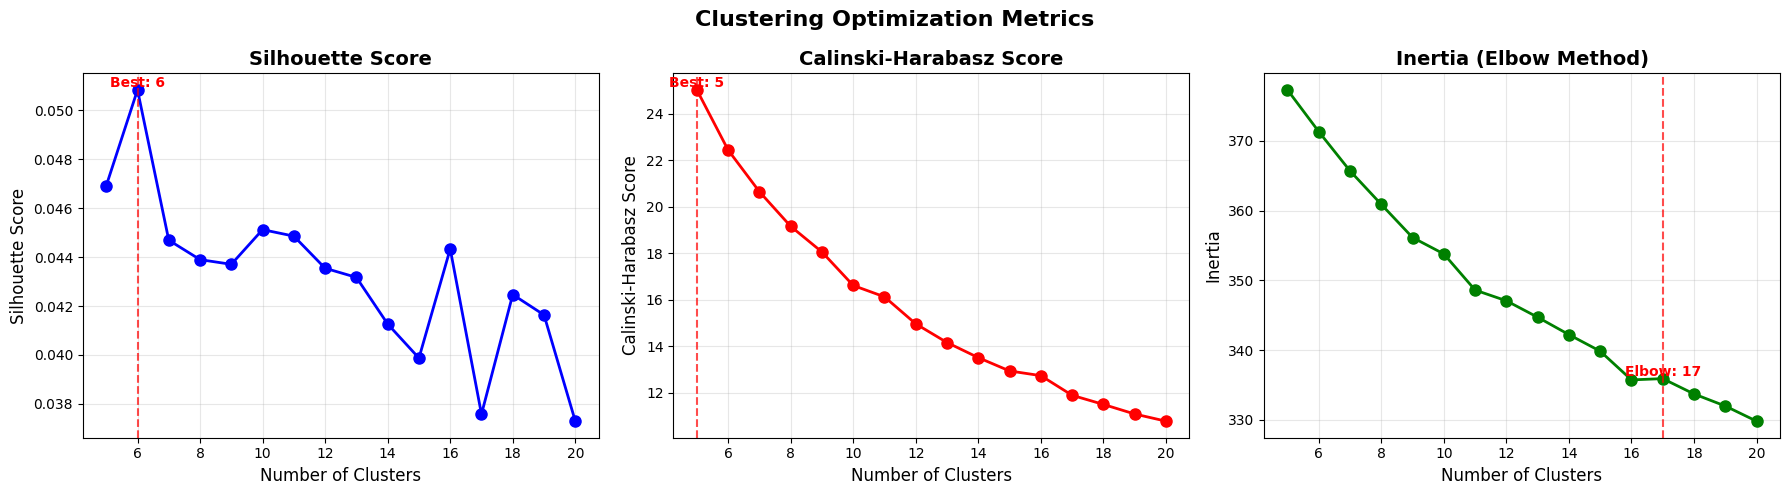

Matplotlib clustering optimization plot: SUCCESS
Optimal number of clusters: 6 (Silhouette score: 0.051)
Performing semantic kmeans clustering with 6 clusters...
Clustering silhouette score: 0.051
Cluster distribution:
  Cluster 0: 43 patents
  Cluster 1: 90 patents
  Cluster 2: 99 patents
  Cluster 3: 155 patents
  Cluster 4: 83 patents
  Cluster 5: 197 patents
Extracting semantic cluster keywords...
Analyzing cluster applicants...
Creating UMAP visualization...


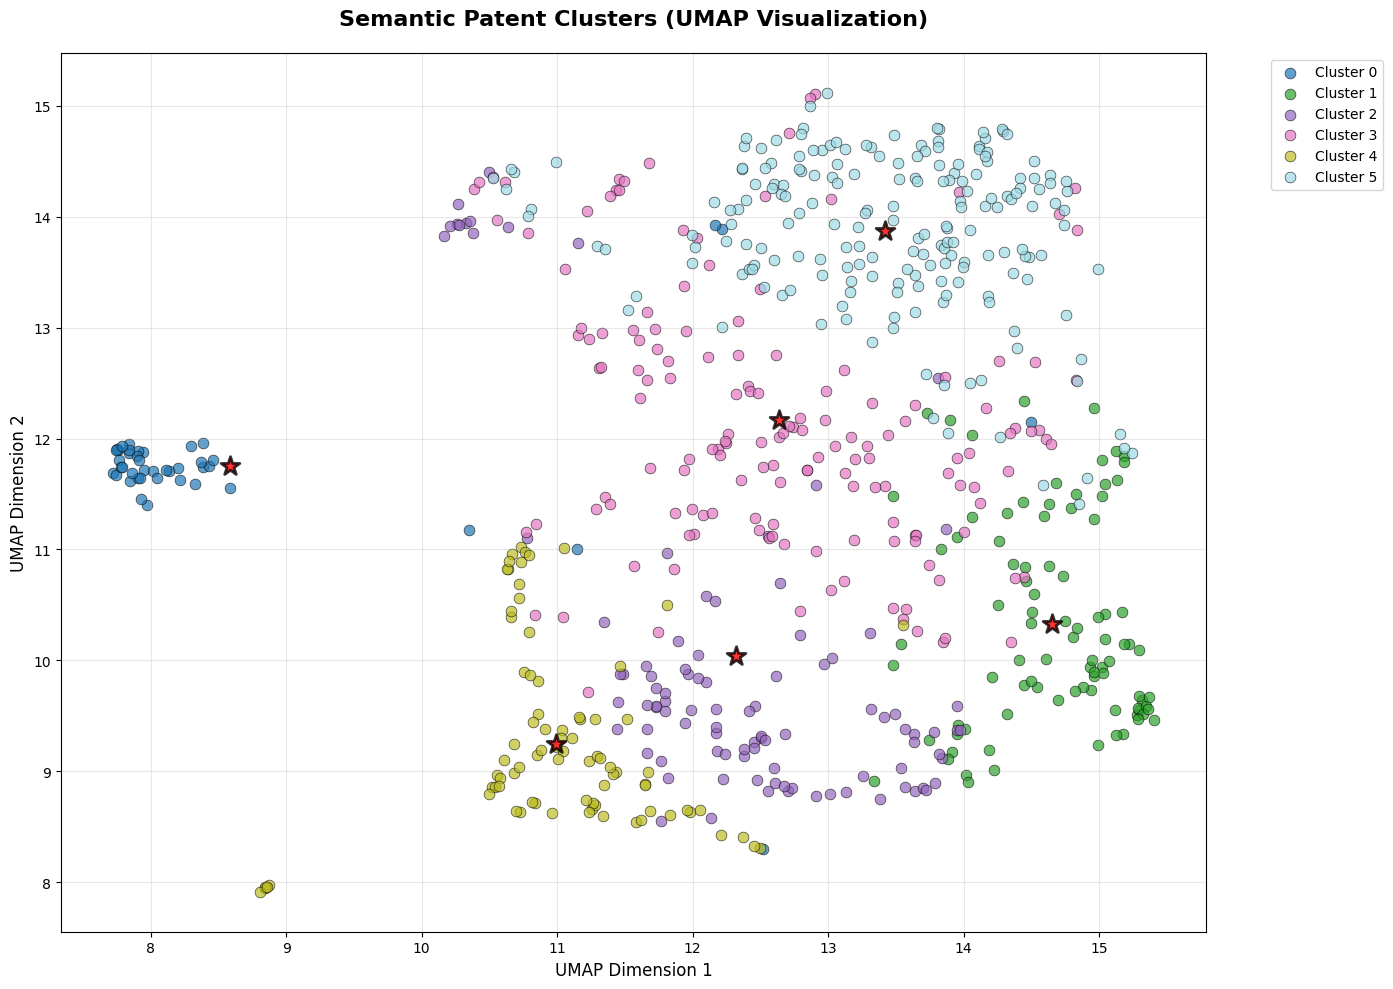

Matplotlib cluster visualization: SUCCESS


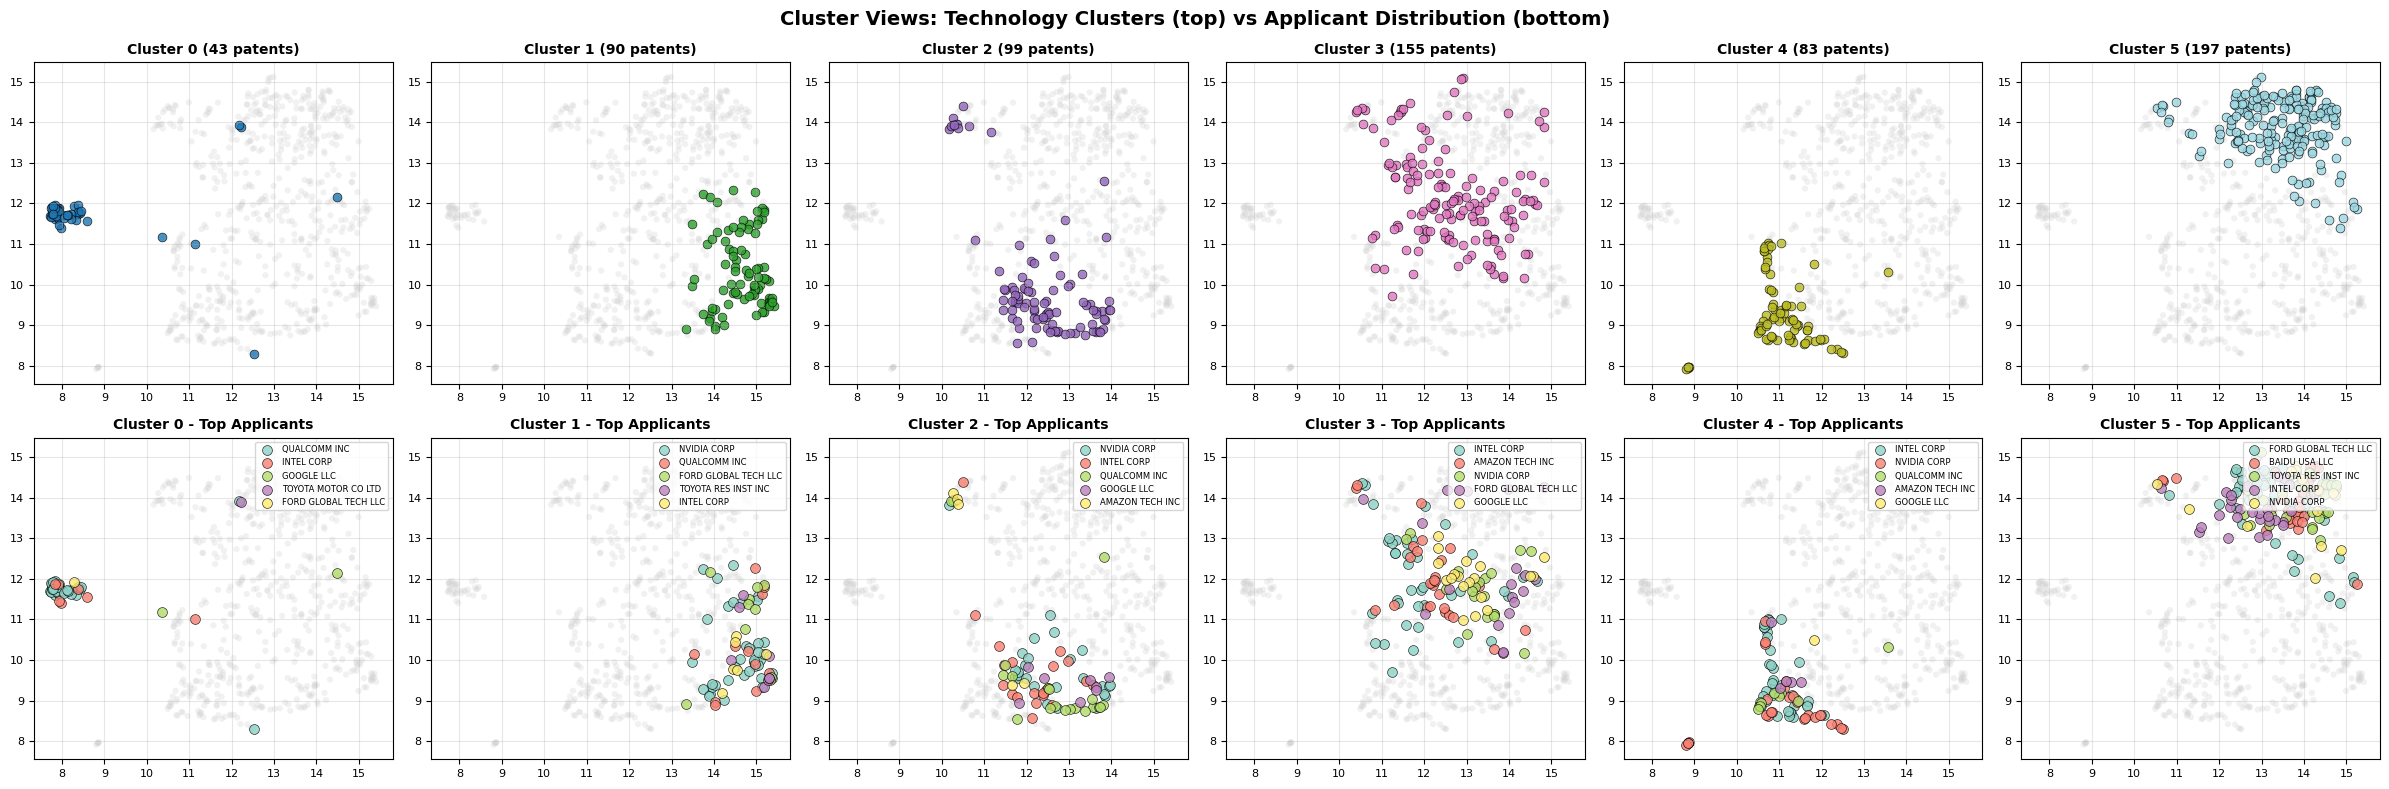

Cluster detail with applicant visualization: SUCCESS


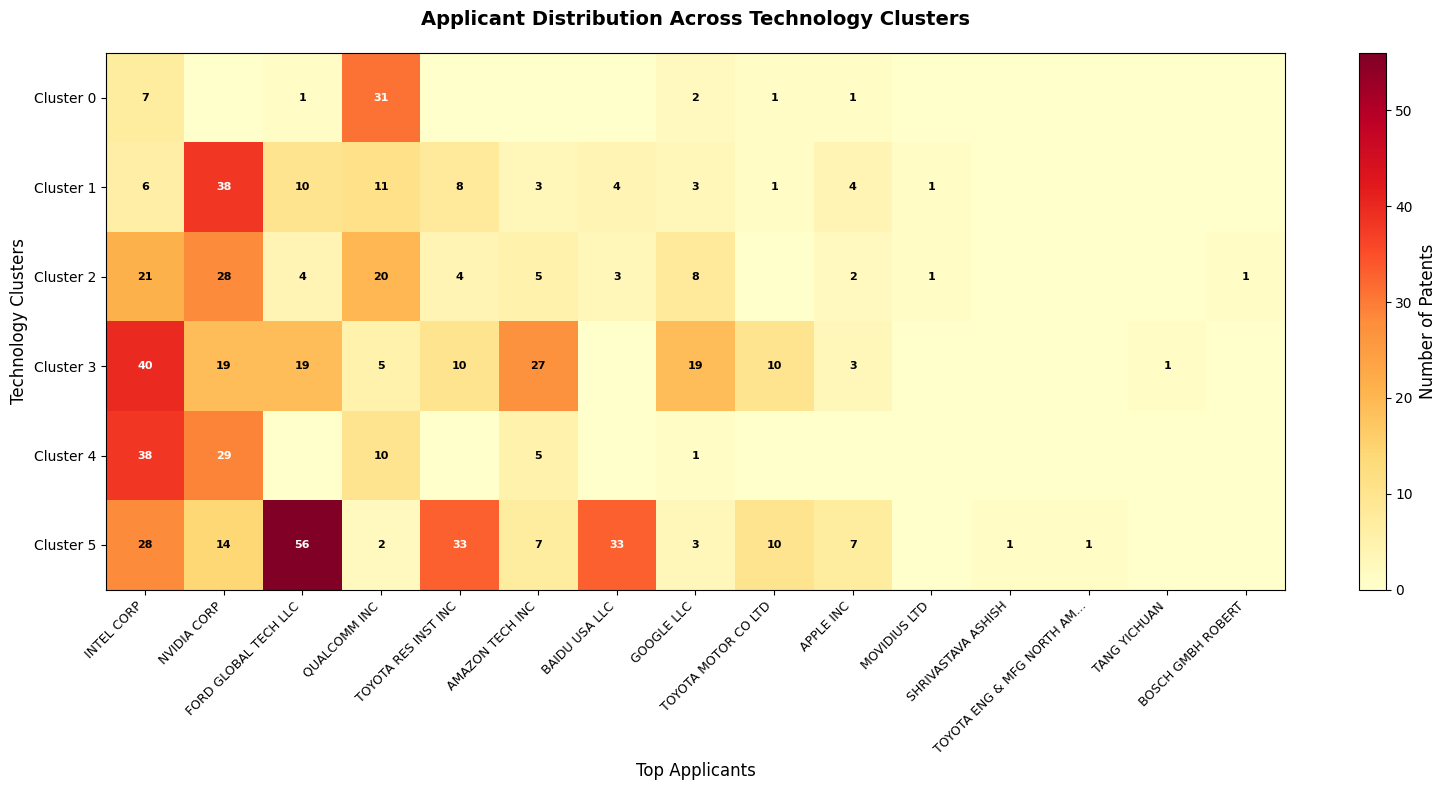

Applicant-cluster heatmap: SUCCESS
Analyzing cluster semantic coherence...
Analyzing cross-cluster similarities...


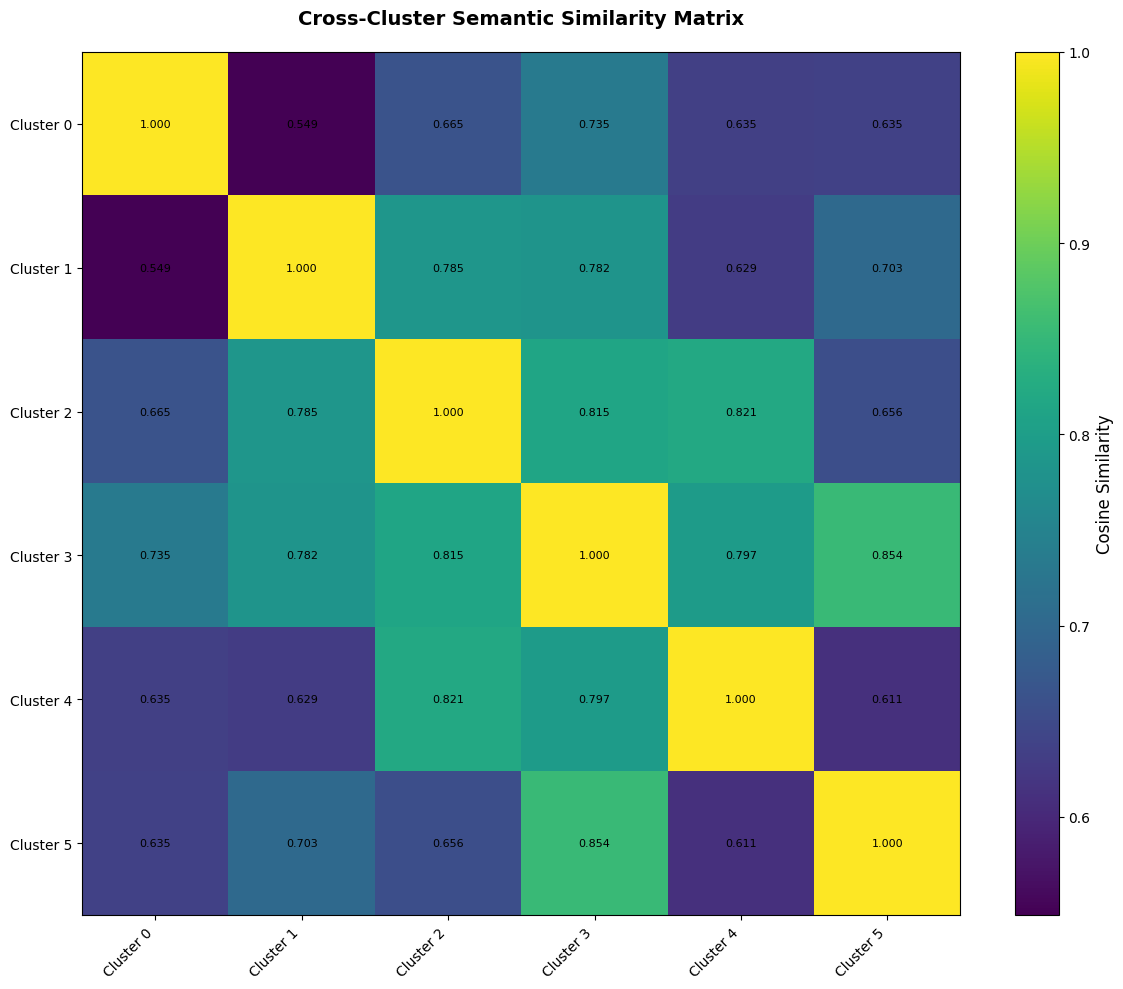

Cross-cluster similarity matrix: SUCCESS

=== SEMANTIC PATENT CLUSTERING REPORT ===

CLUSTER 0 (Semantic Coherence: 0.470):
  Size: 43 patents
  Key concepts: wireless, ue, csi, apparatus, channel, signal, information
  Timeline: 2018-04-05 to 2021-12-06
  Unique applicants: 6
  Leading applicants:
    - QUALCOMM INC: 31 patents (72.1%)
    - INTEL CORP: 7 patents (16.3%)
    - GOOGLE LLC: 2 patents (4.7%)
    - TOYOTA MOTOR CO LTD: 1 patents (2.3%)
    - FORD GLOBAL TECH LLC: 1 patents (2.3%)
  Market concentration: High (HHI: 0.549)
  Top CPC symbols: G06N20/00 (27), G06N3/08 (18), G06N3/045 (18)
  Example patents:
    - Vehicle-to-everything data transfer for automated vehicles
    - Systems and methods for optimizing an antenna topology of a vehicle

CLUSTER 1 (Semantic Coherence: 0.454):
  Size: 90 patents
  Key concepts: image, depth, images, 3d, object, data, camera
  Timeline: 2016-09-09 to 2022-11-30
  Unique applicants: 12
  Leading applicants:
    - NVIDIA CORP: 38 patents (

In [ ]:
# Example usage
if __name__ == "__main__":
    # Initialize semantic clusterer
    clusterer = SemanticPatentClusterer(
        '/content/av_patentdata.jsonl',
        model_name='all-MiniLM-L6-v2'  # Fast and efficient
        # model_name='all-mpnet-base-v2'  # Higher quality, slower
    )

    # Run complete semantic analysis
    results = clusterer.run_complete_semantic_analysis(
        visualization_method='umap'  # or 'tsne'
    )

    print("Semantic analysis completed!")
    print(f"Embedding dimension: {results['embeddings'].shape[1]}")
    print(f"Number of clusters: {len(np.unique(clusterer.cluster_labels))}")

    # Example: Find similar patents
    # similar = clusterer.find_similar_patents(0, top_k=5)
    # print(f"Patents similar to index 0: {[p['title'] for p in similar]}")